In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('glass.xlsx', sheet_name='glass')

In [3]:
df.shape

(214, 10)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


In [5]:
df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [6]:
df.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516522,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


In [7]:
df.isnull().sum()

,0
RI,0
Na,0
Mg,0
Al,0
Si,0
K,0
Ca,0
Ba,0
Fe,0
Type,0


In [8]:
df['Type'].value_counts().sort_index()

,count
Type,
1,70
2,76
3,17
5,13
6,9
7,29


In [10]:
# Check for duplicates
print(f"\nNumber of duplicate rows: {df.duplicated().sum()}")


Number of duplicate rows: 1


In [11]:
# Check for outliers using IQR method
print("\nOutlier Analysis (using IQR method):")
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
outliers = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum()
print("Number of outliers per feature:")
print(outliers)


Outlier Analysis (using IQR method):
Number of outliers per feature:
RI      17
Na       7
Mg       0
Al      18
Si      12
K        7
Ca      26
Ba      38
Fe      12
Type    29
dtype: int64


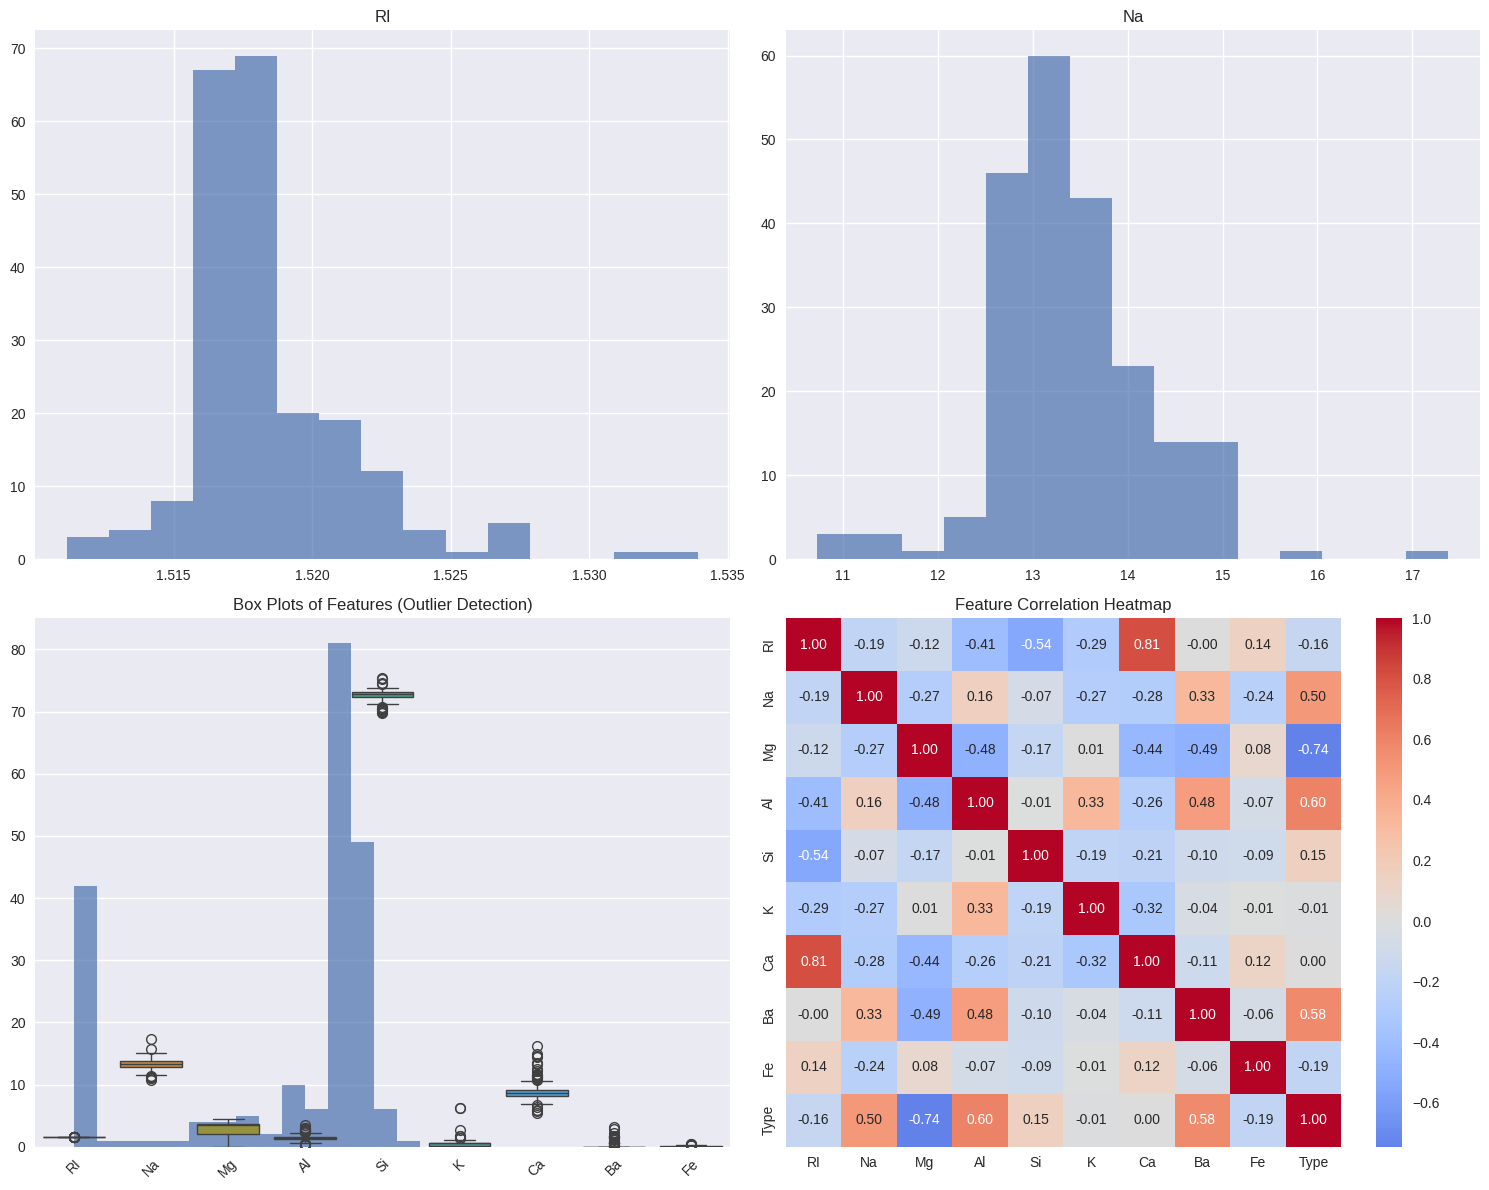

In [13]:
# Set up the plotting style
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 2.1 Target variable distribution
plt.subplot(2, 2, 1)
type_counts = df['Type'].value_counts().sort_index()

# Define a mapping from glass type number to descriptive label
type_mapping = {
    1: 'Float Building',
    2: 'Non-Float Building',
    3: 'Float Vehicle',
    4: 'Non-Float Vehicle', # Type 4 is not present in the data
    5: 'Containers',
    6: 'Tableware',
    7: 'Headlamps'
}

# Create labels for xticks using only the types present in the data
xtick_labels = [f'{idx}\n{type_mapping.get(idx, "Unknown")}' for idx in type_counts.index]

plt.bar(type_counts.index, type_counts.values, color='skyblue', alpha=0.7)
plt.xlabel('Glass Type')
plt.ylabel('Count')
plt.title('Distribution of Glass Types')
plt.xticks(type_counts.index, xtick_labels, rotation=45)

# 2.2 Feature distributions (histograms)
plt.subplot(2, 2, 2)
df[['RI', 'Na', 'Mg', 'Ca']].hist(alpha=0.7, bins=15, ax=plt.gca())
plt.title('Distribution of Key Features')

# 2.3 Box plots for outlier detection
plt.subplot(2, 2, 3)
df_box = df.drop('Type', axis=1)
sns.boxplot(data=df_box, ax=plt.gca())
plt.xticks(rotation=45)
plt.title('Box Plots of Features (Outlier Detection)')

# 2.4 Correlation heatmap
plt.subplot(2, 2, 4)
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            fmt='.2f', ax=plt.gca())
plt.title('Feature Correlation Heatmap')

plt.tight_layout()
plt.show()


Generating pair plot...


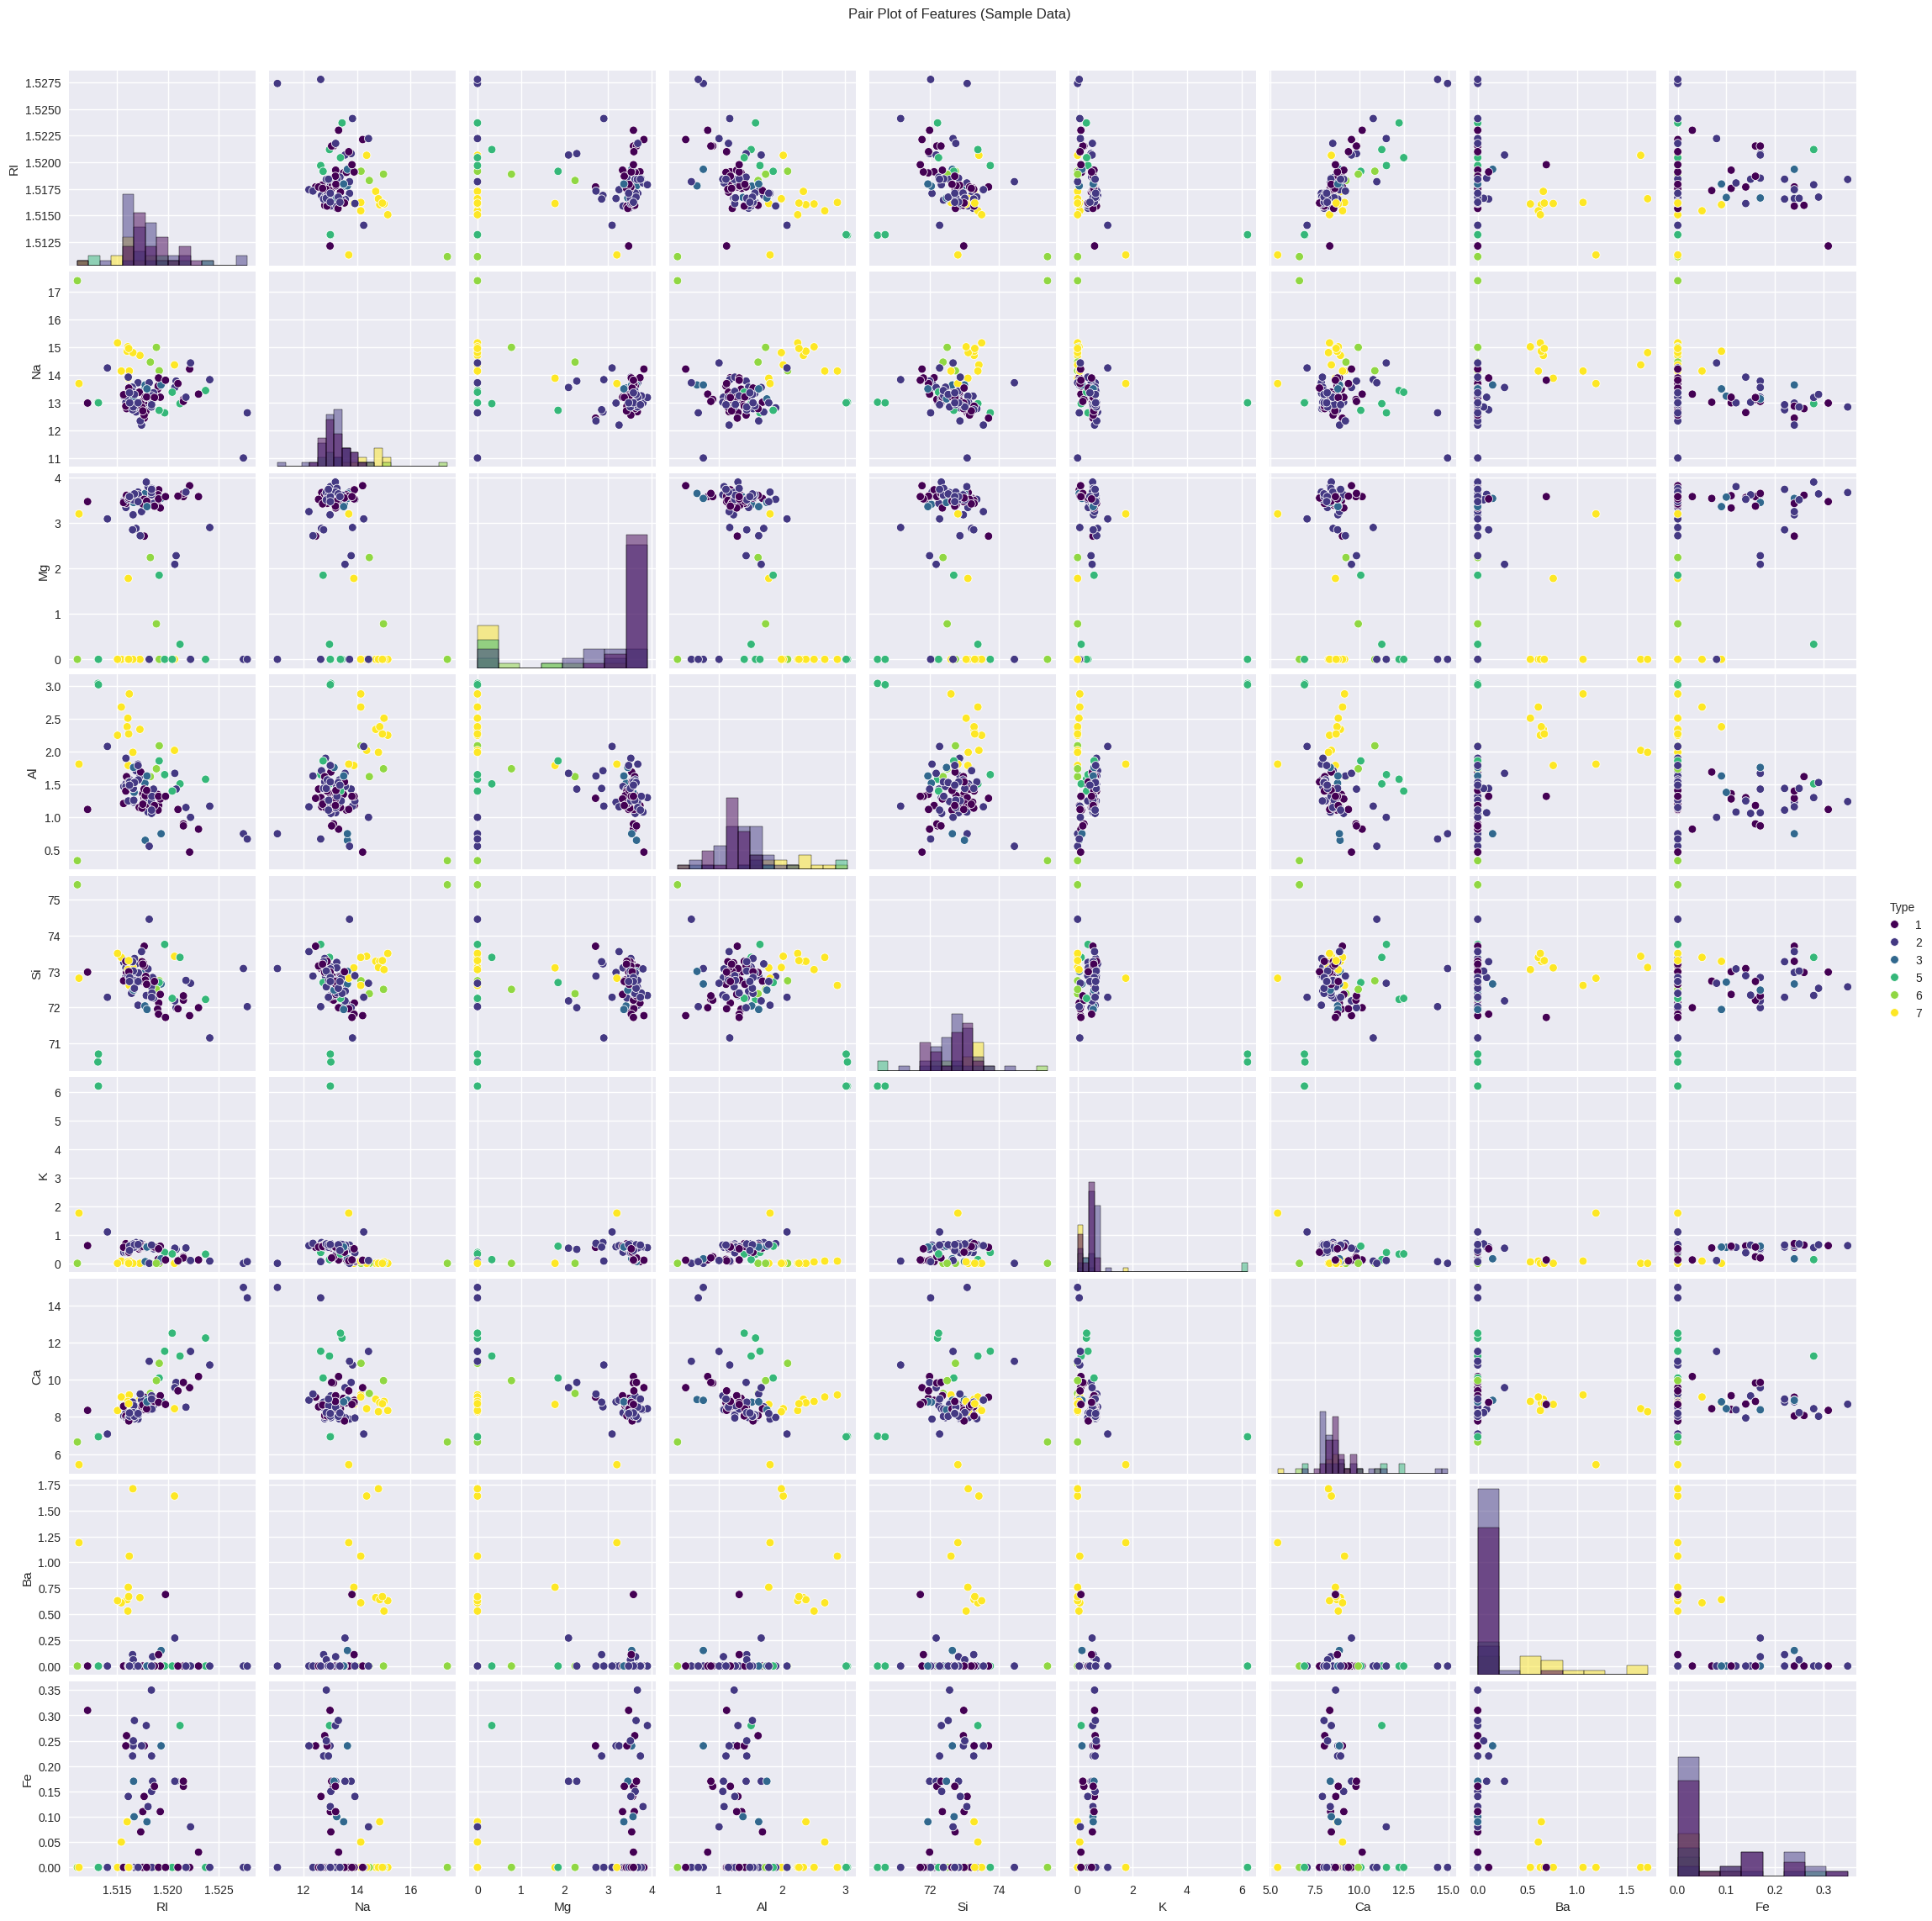

In [14]:
# Pair plot for selected features (sample for better visualization)
print("\nGenerating pair plot...")
sample_df = df.sample(min(100, len(df)), random_state=42)
sns.pairplot(sample_df, hue='Type', diag_kind='hist', palette='viridis')
plt.suptitle('Pair Plot of Features (Sample Data)', y=1.02)
plt.show()

In [15]:
print("Missing values before handling:", df.isnull().sum().sum())

Missing values before handling: 0


In [16]:
# Feature scaling
X = df.drop('Type', axis=1)
y = df['Type']

In [17]:
# Apply standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print("\nFeature scaling applied: Standardization")
print("Features scaled to have mean=0 and std=1")


Feature scaling applied: Standardization
Features scaled to have mean=0 and std=1


In [18]:
# Handling class imbalance
print(y.value_counts().sort_index())

Type
1    70
2    76
3    17
5    13
6     9
7    29
Name: count, dtype: int64


In [19]:
# RANDOM FOREST MODEL IMPLEMENTATION

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 149
Test set size: 65


In [20]:
# Implement Random Forest classifier
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'  # Handle class imbalance
)

In [21]:
# Train the model
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [23]:
# Make predictions and evaluate
y_pred_rf = rf_model.predict(X_test)

In [24]:
# Calculate metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

print("\nRandom Forest Performance:")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1-Score: {f1_rf:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))


Random Forest Performance:
Accuracy: 0.8308
Precision: 0.8396
Recall: 0.8308
F1-Score: 0.8266

Classification Report:
              precision    recall  f1-score   support

           1       0.79      0.90      0.84        21
           2       0.90      0.78      0.84        23
           3       0.67      0.40      0.50         5
           5       0.67      1.00      0.80         4
           6       0.75      1.00      0.86         3
           7       1.00      0.89      0.94         9

    accuracy                           0.83        65
   macro avg       0.80      0.83      0.80        65
weighted avg       0.84      0.83      0.83        65



In [25]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)


Feature Importance:
  feature  importance
2      Mg    0.178624
6      Ca    0.150381
1      Na    0.133819
5       K    0.123472
3      Al    0.117109
0      RI    0.114034
4      Si    0.085110
7      Ba    0.076992
8      Fe    0.020459


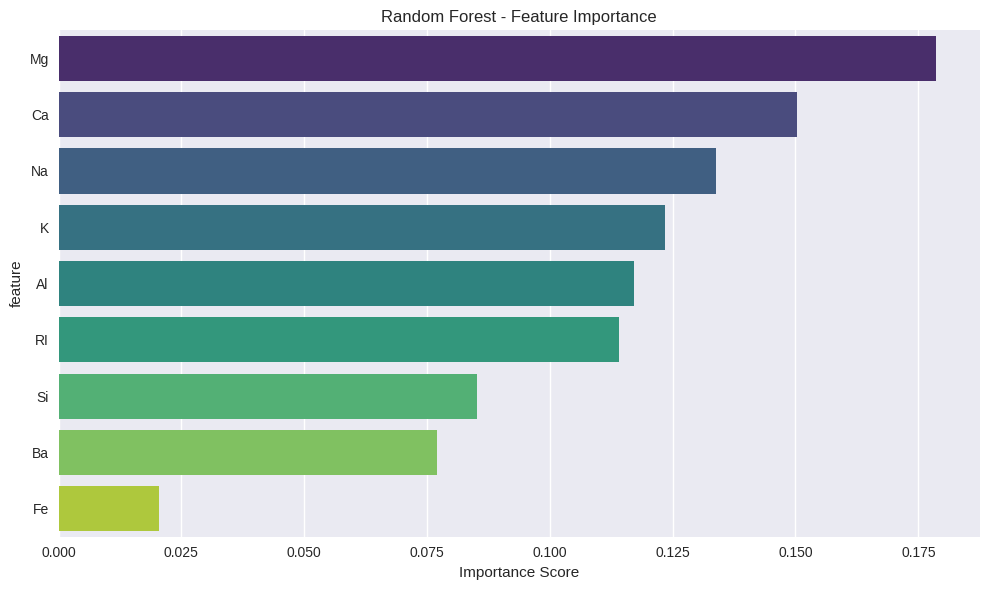

In [26]:
# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')
plt.title('Random Forest - Feature Importance')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

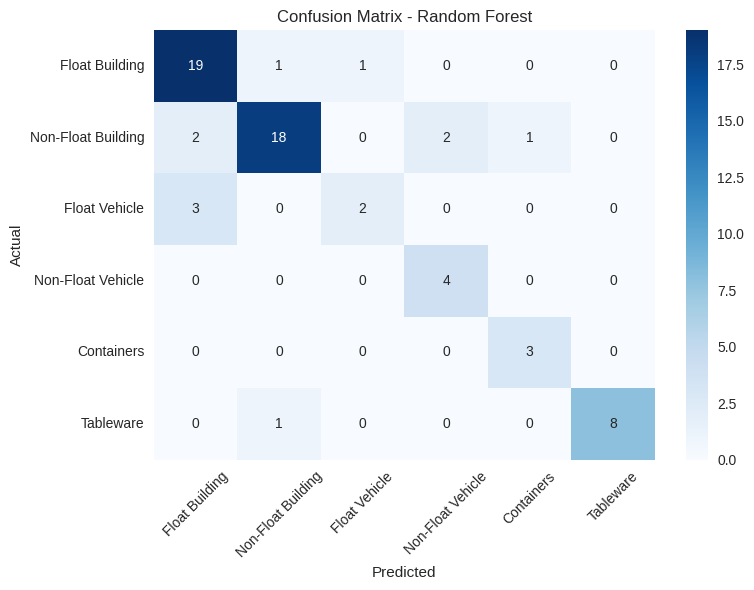

In [27]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=type_labels[:len(np.unique(y))],
            yticklabels=type_labels[:len(np.unique(y))])
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [28]:
# BAGGING AND BOOSTING METHODS

#Bagging Classifier
bagging_model = BaggingClassifier(
    n_estimators=50,
    random_state=42
)
bagging_model.fit(X_train, y_train)
y_pred_bagging = bagging_model.predict(X_test)

In [29]:
# AdaBoost Classifier
adaboost_model = AdaBoostClassifier(
    n_estimators=50,
    random_state=42
)
adaboost_model.fit(X_train, y_train)
y_pred_adaboost = adaboost_model.predict(X_test)

In [30]:
# Gradient Boosting Classifier
gradient_boost_model = GradientBoostingClassifier(
    n_estimators=100,
    random_state=42
)
gradient_boost_model.fit(X_train, y_train)
y_pred_gradient = gradient_boost_model.predict(X_test)

In [31]:
# Compare results
models = {
    'Random Forest': y_pred_rf,
    'Bagging': y_pred_bagging,
    'AdaBoost': y_pred_adaboost,
    'Gradient Boost': y_pred_gradient
}

results = []
for name, y_pred in models.items():
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df.round(4))


Model Comparison:
            Model  Accuracy  Precision  Recall  F1-Score
0   Random Forest    0.8308     0.8396  0.8308    0.8266
1         Bagging    0.8308     0.8332  0.8308    0.8259
2        AdaBoost    0.4615     0.4675  0.4615    0.4218
3  Gradient Boost    0.8154     0.8332  0.8154    0.8054


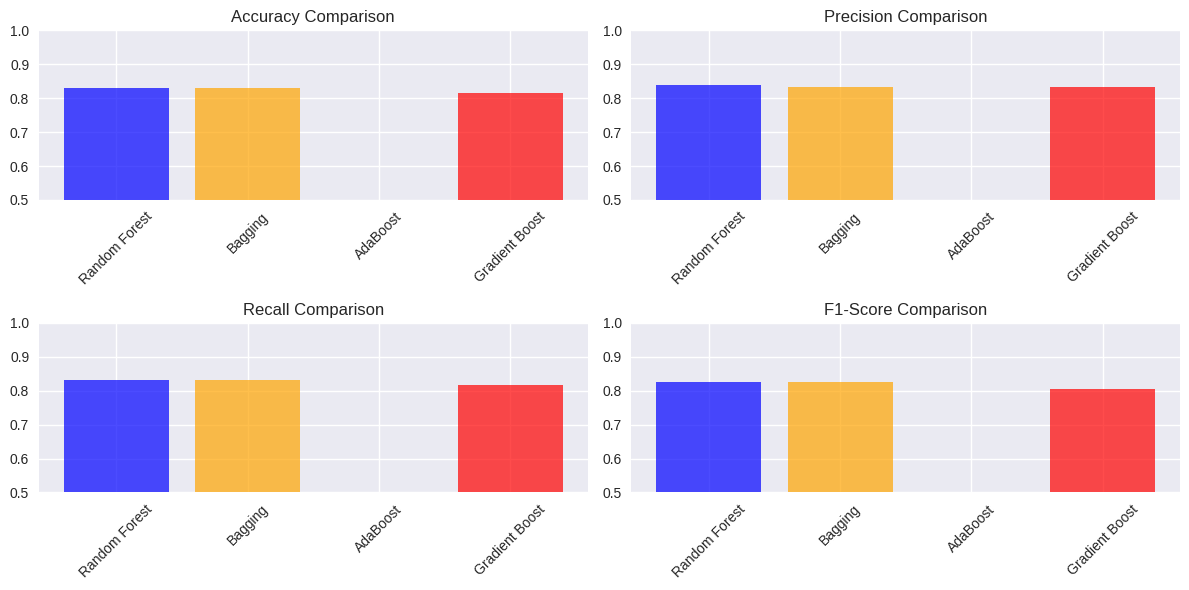

In [32]:
# Visualization of model comparison
plt.figure(figsize=(12, 6))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x_pos = np.arange(len(results_df))

for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    plt.bar(results_df['Model'], results_df[metric], color=['blue', 'orange', 'green', 'red'], alpha=0.7)
    plt.title(f'{metric} Comparison')
    plt.xticks(rotation=45)
    plt.ylim(0.5, 1.0)

plt.tight_layout()
plt.show()

In [33]:
# ADDITIONAL NOTES EXPLANATION

print("=== ADDITIONAL NOTES ===")

print("\n1. BAGGING AND BOOSTING METHODS:")

print("""
BAGGING (Bootstrap Aggregating):
- Creates multiple subsets of the original dataset through bootstrapping (random sampling with replacement)
- Trains a model on each subset independently
- Combines predictions through voting (classification) or averaging (regression)
- Reduces variance and helps prevent overfitting
- Example: Random Forest (which uses both bagging and feature randomness)

BOOSTING:
- Trains models sequentially, where each model tries to correct the errors of the previous one
- Gives more weight to misclassified instances in subsequent models
- Combines weak learners to create a strong learner
- Reduces bias and can achieve high accuracy
- Examples: AdaBoost, Gradient Boosting, XGBoost

KEY DIFFERENCES:
1. Training Approach: Bagging trains models in parallel; Boosting trains sequentially
2. Weighting: Bagging gives equal weight to all instances; Boosting gives more weight to misclassified instances
3. Focus: Bagging reduces variance; Boosting reduces bias
4. Performance: Bagging good for high-variance models; Boosting often achieves higher accuracy
""")

print("\n2. HANDLING IMBALANCED DATA:")

print("""
STRATEGIES FOR IMBALANCED DATA:

1. Resampling Techniques:
   - Oversampling: Increase minority class samples (SMOTE, Random Oversampling)
   - Undersampling: Reduce majority class samples (Random Undersampling)

2. Algorithm-level Approaches:
   - Use class weights to give more importance to minority classes
   - Choose algorithms that handle imbalance well (like Random Forest with class weights)

3. Evaluation Metrics:
   - Use appropriate metrics: F1-score, Precision, Recall instead of just Accuracy
   - Use confusion matrix for detailed analysis
   - Consider ROC-AUC for binary classification

4. Ensemble Methods:
   - Use balanced Random Forest
   - Apply boosting algorithms that naturally handle imbalance

In this implementation, we used:
- Class weights in Random Forest ('balanced' parameter)
- Appropriate evaluation metrics (F1-score, precision, recall)
- Stratified train-test split to maintain class distribution
""")

=== ADDITIONAL NOTES ===

1. BAGGING AND BOOSTING METHODS:

BAGGING (Bootstrap Aggregating):
- Creates multiple subsets of the original dataset through bootstrapping (random sampling with replacement)
- Trains a model on each subset independently
- Combines predictions through voting (classification) or averaging (regression)
- Reduces variance and helps prevent overfitting
- Example: Random Forest (which uses both bagging and feature randomness)

BOOSTING:
- Trains models sequentially, where each model tries to correct the errors of the previous one
- Gives more weight to misclassified instances in subsequent models
- Combines weak learners to create a strong learner
- Reduces bias and can achieve high accuracy
- Examples: AdaBoost, Gradient Boosting, XGBoost

KEY DIFFERENCES:
1. Training Approach: Bagging trains models in parallel; Boosting trains sequentially
2. Weighting: Bagging gives equal weight to all instances; Boosting gives more weight to misclassified instances
3. Focus: Ba

In [34]:
# Final summary
print("\n=== FINAL SUMMARY ===")
best_model = results_df.loc[results_df['F1-Score'].idxmax()]
print(f"Best performing model: {best_model['Model']}")
print(f"Best F1-Score: {best_model['F1-Score']:.4f}")
print(f"Best Accuracy: {best_model['Accuracy']:.4f}")

print("\nKey Insights:")
print("1. The dataset contains 214 samples with 9 features and 7 glass types")
print("2. Some glass types are underrepresented (imbalanced dataset)")
print("3. Random Forest with class weights performed well in handling imbalance")
print("4. Feature importance shows RI, Mg, and Al are most important for classification")


=== FINAL SUMMARY ===
Best performing model: Random Forest
Best F1-Score: 0.8266
Best Accuracy: 0.8308

Key Insights:
1. The dataset contains 214 samples with 9 features and 7 glass types
2. Some glass types are underrepresented (imbalanced dataset)
3. Random Forest with class weights performed well in handling imbalance
4. Feature importance shows RI, Mg, and Al are most important for classification
